<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/train_lfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install pathy -q
!pip install comet_ml -q
!pip install umap-learn

     |████████████████████████████████| 1.8MB 6.4MB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 163kB 19.6MB/s 
     |████████████████████████████████| 133kB 12.8MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 122kB 7.8MB/s 
     |████████████████████████████████| 266kB 7.1MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 522kB 58.1MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 1.2MB 10.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=d5c8f0e8589dd5aa239f730bb853048f443dcc0e8b1b04ca1d575db2c7aaf3aa
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for 

In [2]:
# import comet_ml at the top of your file
from comet_ml import Experiment
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=40, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=2048, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-lg', '--goal_mapper_layer_size', default=512, type=int, help='Layer size of goal mapping networks from im and sent to goal space, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-s_embd', '--sentence_embedding_size', default=512, type=int, help='Embedding size of MUSE sentence embeddings')
parser.add_argument('-g_embd', '--gripper_img_embedding_size', default=32, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-zg', '--goal_space_dim', default=32, type=int, help='Size of the goal embedding space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('-gi', '--gripper_images', default=False, action='store_true')
parser.add_argument('-sim', '--sim', default='Unity', help='Unity/Pybullet')
parser.add_argument('-vq', '--discrete', default=False, action='store_true')
parser.add_argument('-nm', '--normalize', default=False, action='store_true')
parser.add_argument('-lang', '--use_language', default=False, action='store_true')
parser.add_argument('-cont', '--use_contrastive', default=False, action='store_true')
parser.add_argument('-sub', '--sub_out_language_percent',  type=float, default=0.25)
parser.add_argument('--fp16', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP

# ## Sample colab config
# args = parser.parse_args('''
# refactor_test
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -tfr
# -s GCS
# -d TPU
# -b 512
# -la 2048
# -le 512
# -lp 2048
# -z 256
# -lr 3e-4
# --bucket_name iowa_bucket_lfp
# '''.split())



# ## Sample colab config
# args = parser.parse_args('''
# PB0_02
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -s GCS
# -d TPU
# -b 16
# -la 2048
# -le 512
# -lp 2048
# -wmax 40
# -wmin 20
# -z 256
# -lr 3e-4
# -B 0.02
# -i 
# -tfr
# -n 5
# --bucket_name iowa_bucket_lfp
# '''.split())

## Sample colab config
args = parser.parse_args('''
test
--train_dataset Unity/envHz25
--test_dataset Unity/envHz25_test
-c
-s GCS
-d TPU
-b 512
-la 2048
-le 512
-lp 2048
-wmax 40
-wmin 20
-z 256
-lr 3e-4
-B 0.0
-tfr
-n 5
--bucket_name iowa_bucket_lfp
'''.split())

# args = parser.parse_args('''
# discrete4096_batch
# --train_dataset Unity/UR5_train
# --test_dataset Unity/UR5_test
# -c
# -tfr
# -s GCS
# -d TPU
# -b 512
# -la 2048
# -le 512
# -lp 8
# -z 4096
# -lr 3e-4
# -B 0.01
# --bucket_name iowa_bucket_lfp
# '''.split())

# -n 5
# -q 8

print(args)

Namespace(actor_layer_size=16, batch_size=4, beta=0.0, bucket_name='iowa_bucket_lfp', colab=True, data_source='GCS', device='TPU', discrete=False, encoder_layer_size=16, fp16=False, from_tfrecords=True, gcbc=False, goal_mapper_layer_size=512, goal_space_dim=32, gripper_images=False, gripper_img_embedding_size=32, images=False, img_embedding_size=64, latent_dim=256, learning_rate=0.0003, normalize=False, num_distribs=5, planner_layer_size=16, qbits=None, resume=False, run_name='test', sentence_embedding_size=512, sim='Unity', sub_out_language_percent=0.25, test_datasets=['Unity/envHz25_test'], tpu_name=None, train_datasets=['Unity/envHz25'], train_steps=200000, use_contrastive=False, use_language=False, window_size_max=40, window_size_min=20)


## Init

In [5]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/learning_from_play')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/learning_from_play' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to learning_from_play
os.chdir(WORKING_PATH)
import lfp

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into '/content/learning_from_play'...
remote: Enumerating objects: 3100, done.
remote: Counting objects: 100% (620/620), done.
remote: Compressing objects: 100% (447/447), done.
remote: Total 3100 (delta 432), reused 315 (delta 172), pack-reused 2480
Receiving objects: 100% (3100/3100), 133.09 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (1910/1910), done.
Mounted at /content/drive
No pybullet installation found - which is fine if training


Reading data from Google Cloud Storage
Storage path: gs://iowa_bucket_lfp/


In [6]:

print("Tensorflow version " + tf.__version__)

if args.device == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=args.tpu_name)  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
    if args.fp16:
        tf.keras.mixed_precision.set_global_policy('mixed_bfloat16')
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
        if args.fp16:
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
    strategy = tf.distribute.get_strategy()
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.77.56.50:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.77.56.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.56.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [13]:
# Use this to edit modules without needing to restart the kernel (can also edit local, push/pull)
!git pull
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)
importlib.reload(lfp.metric)

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/sholtodouglas/learning_from_play
   3992586..1affd15  master     -> origin/master
Updating 3992586..1affd15
Fast-forward
 lfp/train.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


<module 'lfp.metric' from '/content/learning_from_play/lfp/metric.py'>

## Data

In [17]:


GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES
dl = lfp.data.PlayDataloader(normalize=args.normalize, include_imgs = args.images, include_gripper_imgs = args.gripper_images, sim=args.sim, batch_size=GLOBAL_BATCH_SIZE,  window_size=args.window_size_max, min_window_size=args.window_size_min)
dl.shuffle_size

1280

In [18]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)

{   'acts': TensorSpec(shape=(32, None, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(32, None), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(32, None, 12), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(32, None, 19), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(32, None), dtype=tf.int32, name=None)}


In [19]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)

{   'acts': TensorSpec(shape=(32, None, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(32, None), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(32, None, 12), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(32, None, 19), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(32, None), dtype=tf.int32, name=None)}


# Training Loop

In [28]:

from lfp.train import LFPTrainer


if args.device=='CPU' or args.device=='GPU':
     actor, encoder, planner, cnn, gripper_cnn,  img_embed_to_goal_space, lang_embed_to_goal_space, trainer =lfp.train.train_setup(args, dl, GLOBAL_BATCH_SIZE, strategy=None)
else:
    with strategy.scope():
         actor, encoder, planner, cnn, gripper_cnn,  img_embed_to_goal_space, lang_embed_to_goal_space, trainer = lfp.train.train_setup(args, dl, GLOBAL_BATCH_SIZE, strategy=strategy)
        
        
        
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

plotting_background_dataset = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset
# For use with lang and plotting the colored dots
labelled_dl = lfp.data.labelled_dl(batch_size=64)
labelled_test_ds = iter(labelled_dl.load(labelled_dl.extract(TEST_DATA_PATHS)))

if args.use_language:
  lang_dl = lfp.data.labelled_dl(batch_size=GLOBAL_BATCH_SIZE, shuffle_size = 64) # this is probably fine as it is preshuffled during creation
  train_dist_lang_dataset = iter(strategy.experimental_distribute_dataset(lang_dl.load(lang_dl.extract(TRAIN_DATA_PATHS))))
  valid_dist_lang_dataset = iter(strategy.experimental_distribute_dataset(lang_dl.load(lang_dl.extract(TEST_DATA_PATHS))))

In [ ]:

from tensorflow.keras.utils import Progbar
progbar = Progbar(args.train_steps, verbose=1, interval=0.5)
valid_inc = 20
save_inc = 2000

In [ ]:
run_name = args.run_name
model_path = str(STORAGE_PATH/'saved_models'/args.run_name)

if args.resume:
  # WandB reinit
  with open(f'{model_path}/config.json', 'r') as f:
      data = json.load(f)
  # Comet ML reinit
  exp = ExistingExperiment(api_key="C4vcCM57bnSYEsdncguxDW8pO",  previous_experiment=data['experiment_key'])

  wandb.init(project="learning-from-play_v2", id=data['run_id'],  resume="must")
  t = wandb.run.step + valid_inc # Todo get this from comet to complete the transition

  load_weights(model_path, actor, encoder, planner, with_optimizer=True)
  print('Loaded model weights and optimiser state')
  
  prognar.add(t, []) # update the progbar to the most recent point
else:
  #Comet
  experiment = Experiment(api_key="C4vcCM57bnSYEsdncguxDW8pO",project_name="learning-from-play",workspace="sholtodouglas")
  experiment.set_name(run_name)
  # WandB
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/sholtodouglas/learning-from-play/c0fe531e07464652af9b95fd43ea1753
COMET INFO:   Others:
COMET INFO:     Name : test
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sholtodouglas/learning-from-play/4d724a2c693248d0ba9a194815bf2e68



In [ ]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
from lfp.metric import log # gets state and clears simultaneously

In [ ]:
import time


In [ ]:
def step(dataset, beta, f, lang_dataset=None):
    batch = next(dataset)
    lang_batch = next(lang_dataset) if args.use_language else None
    f(batch, beta, lang_batch)

    
while t < args.train_steps:
    start_time = time.time()
    step(train_dist_dataset, args.beta, trainer.distributed_train_step, train_dist_lang_dataset)

    if t % valid_inc == 0:
        step(valid_dist_dataset, args.beta, trainer.distributed_test_step, valid_dist_lang_dataset)
        step_time = round(time.time() - start_time, 1)

        metrics = {metric_name: log(metric) for metric_name, metric in trainer.metrics.items()}
        metrics['step_time'] = step_time

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', metrics['train_loss']),
                                ('Validation Loss', metrics['valid_loss']),
                                ('Time (s)', step_time)])
        #Plot on Comet
        experiment.log_metrics(metrics,step=t)
        # Plot on WandB
        wandb.log(metrics, step=t)

    if (t+0) % save_inc == 0: # zero while we test this
        trainer.save_weights(model_path, run_id=wandb.run.id, experiment_key=experiment.get_key())

        # How we plot the cluster figs
        batches = [trainer.make_sequences_variable_length(plotting_background_dataset.next()) for i in range(0,4)]
        super_batch = {}
        for k in batches[0].keys():
            super_batch[k] = np.concatenate([b[k] for b in batches])
        lang_batch = labelled_test_ds.next()
        fig_enc, fig_plan, z_enc, z_plan = lfp.plotting.produce_cluster_fig(super_batch, lang_batch, trainer, args=args)
        #if not args.gcbc and not args.images:
        #   z_enc, z_plan = produce_cluster_fig(next(plotting_dataset), encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size//4)

        #   #Comet
        #   experiment.log_figure('z_enc', z_enc, step=t)
        #   experiment.log_figure('z_plan', z_plan,step=t)

        # WandB
        wandb.log({'z_enc':lfp.plotting.plot_to_image(fig_enc), 'z_plan':lfp.plotting.plot_to_image(fig_plan)}, step=t)

          #latent_fig = project_enc_and_plan(ze, zp)
          #latent_img = plot_to_image(latent_fig)

    t += 1

  2360/200000 [..............................] - ETA: 59:21:30 - Train Loss: -1.9586 - Validation Loss: 5.1121 - Time (s): 3.4161

KeyboardInterrupt: ignored

In [ ]:
batch = plotting_dataset.next()

In [ ]:

batch = trainer.make_sequences_variable_length(batch)
enc_policy, plan_policy, encoding, plan = trainer.step(batch)

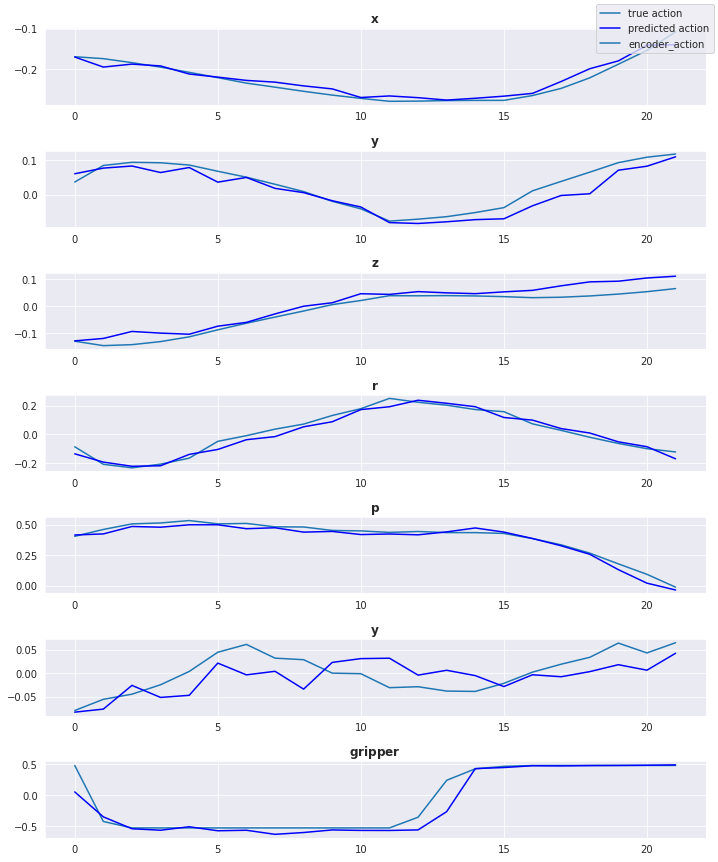

In [ ]:
#@title Plot timeseries of state/action tracking over time - xyz rpy gripper
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

idx = 450
seq_len = tf.cast(batch['seq_lens'][idx], tf.int32)
x = np.arange(seq_len)
labels = ['x','y','z','r','p','y','gripper']
fig, axes = plt.subplots(dl.act_dim, 1, figsize=(10,12), squeeze=True)
for i in range(dl.act_dim):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(batch['acts'][idx,:seq_len,i])
    #axes[i].plot(plan_policy[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not args.gcbc:
      sns.lineplot(x=x, y=enc_policy[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()

In [ ]:
 from tqdm import tqdm
t = time.time()
for i in tqdm(range(0,10)):
  train_batch = next(train_dist_dataset)
  trainer.distributed_train_step(train_batch, args.beta)
print(time.time() - t)

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

3.469046115875244
